### Employer Project: Kite

# Data Cleaning and Exploratory Data Analysis. 

In this Jupyter Notebook we have looked to clean the data provided to us by Kite. We were provided with three sheets: 'Customers', 'Order Details', and 'Orders'. We cleaned each sheet in sub groups and then joined the cleaned versions together to get a master joined data set. Once we had this, we then reviewed the business objective (reduce courier costs by 20% within the 50-mile radius around Coventry distribution centre) and created a data set that only looked at customers within the 50-mile radius around the Coventry distribution centre. Our final data set, and the one we decided to use for our analysis, was called miles50_coventry. *Our data analysis using this data set is in the Jupyter Notebook titled 'Geographic, Courier, and Cost Saving Analysis'*
Note: This notebook requires the UK-Postcodes.csv and kitepostcode.csv files in order to run successfully. 

### Importing Necessary Libraries 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

!pip install openpyxl
!pip install cryptography

!pip install msoffcrypto-tool
import msoffcrypto
import io

!pip install haversine
import haversine as hs
from haversine import haversine_vector, Unit

# 

##  Data Cleaning: Customers Sheet

**'Customers' sheet data cleaning methodology:**
<br>

1. There are no duplicates in Website ID.
<br>

2. There are 65 customers with empty postcode & country.
<br>
3. Some inconsistencies observed related to the postcodes:
    - UK postcodes are split into an outward and inward code. The official format of an outward codes is 2-4 characters, however, we have seen some with 5 characters. In this case, we have added a space between the 4th and 5th character. For this, we have made the assumption that the 5th character is the initial digit of the inward code.
    - An outward code should always start with a letter. There is one code (0X15 6) which started with 0. We have replaced 0 with O, assuming this was a mistake when inputting the data.
    - Two postcodes (NE3 1 and TW1 1) had spaces in the beginning of the code. Here, we have removed the spaces.
    - The raw postcodes without any space were considered as missing a space, therefore to extract the outward code, we always leave out the last digit of the provided code.
    - There are some postcodes with a mix of upper and lower case letters. For these, we converted all letters to uppercase. <br><br> 

4. As a result of the steps taken to extract the outward codes (described in point 3 above), we were able to create coordinates (latitude and longitude) for each postcode using the CSV file found through this link: https://www.101computing.net/uk-postcode-distance-calculator/. This proved succesful for all but three of the postcodes (MW18, EI, NQ34 7).

In [2]:
# Decrypting the Excel file to open it in Python
# Looking at the Customers sheet
file_name = "kite_orders_data.xlsx"
sheet_name = "Customers"
password = "FRMay23"

with open(file_name, "rb") as file:
    decryptor = msoffcrypto.OfficeFile(file)
    decryptor.load_key(password=password)
    
    decrypted_data = io.BytesIO()
    decryptor.decrypt(decrypted_data)
    decrypted_data.seek(0)
    
    # Storing the sheet in a Pandas DataFrame called customers
    customers = pd.read_excel(decrypted_data, sheet_name=sheet_name, engine='openpyxl')

In [3]:
# Checking this has worked
customers.head()

,WebsiteID,DeliveryPostCode,DeliveryCountry
0,245,L39 2,United Kingdom
1,597,PR3 1,United Kingdom
2,863,PE2 9,United Kingdom
3,2180,LN5 8,United Kingdom
4,2644,BD10 9,United Kingdom


In [4]:
# Looking at info for the customers DataFrame
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18727 entries, 0 to 18726
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   WebsiteID         18727 non-null  int64 
 1   DeliveryPostCode  18662 non-null  object
 2   DeliveryCountry   18662 non-null  object
dtypes: int64(1), object(2)
memory usage: 439.0+ KB


In [5]:
# Identifying the shape of the DataFrame
customers.shape

(18727, 3)

In [6]:
# Renaming columns for clarity 
customers2 = pd.DataFrame(customers.rename(columns = {'WebsiteID':'customerID',
                                                      'DeliveryPostCode':'cust_postcode',
                                                      'DeliveryCountry':'country'}))
# Viewing the DataFrame                                                     
customers2.head()

,customerID,cust_postcode,country
0,245,L39 2,United Kingdom
1,597,PR3 1,United Kingdom
2,863,PE2 9,United Kingdom
3,2180,LN5 8,United Kingdom
4,2644,BD10 9,United Kingdom


In [7]:
# Changing the customerID to string data type
customers2['customerID'] =  customers2['customerID'].astype(str)

# Checking this has worked
customers2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18727 entries, 0 to 18726
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     18727 non-null  object
 1   cust_postcode  18662 non-null  object
 2   country        18662 non-null  object
dtypes: object(3)
memory usage: 439.0+ KB


In [8]:
# Extracting the outward code from postcode by splitting where there is a space
customers2[['outward1','inward1']] = customers2.cust_postcode.str.split(expand=True)

# Viewing the DataFrame 
customers2.head()

,customerID,cust_postcode,country,outward1,inward1
0,245,L39 2,United Kingdom,L39,2
1,597,PR3 1,United Kingdom,PR3,1
2,863,PE2 9,United Kingdom,PE2,9
3,2180,LN5 8,United Kingdom,LN5,8
4,2644,BD10 9,United Kingdom,BD10,9


In [9]:
# Viewing the info for this DataFrame with the new columns
customers2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18727 entries, 0 to 18726
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     18727 non-null  object
 1   cust_postcode  18662 non-null  object
 2   country        18662 non-null  object
 3   outward1       18662 non-null  object
 4   inward1        18094 non-null  object
dtypes: object(5)
memory usage: 731.6+ KB


In [10]:
# Checking for null values
customers2.isnull().sum()

customerID         0
cust_postcode     65
country           65
outward1          65
inward1          633
dtype: int64

In [11]:
# Calculating the length of the extracted outward codes (format should be 2-4 characters)
customers2['outward1_len'] = customers2['outward1'].str.len()

# Viewing these lengths
customers2['outward1_len']

0        3.0
1        3.0
2        3.0
3        3.0
4        4.0
        ... 
18722    3.0
18723    3.0
18724    4.0
18725    4.0
18726    2.0
Name: outward1_len, Length: 18727, dtype: float64

In [12]:
# Replacing blank cells in outward1_len with NaN
customers2['outward1_len'].fillna(0,inplace=True)

# Changing the data type of outward1_len from float to integer
customers2['outward1_len'] = customers2['outward1_len'].astype(int)

# Identifying the different lengths of outward codes
customers2['outward1_len'].unique()

array([3, 4, 2, 5, 0])

In [13]:
# Extracting only the first 4 characters of the outward codes
# (outward codes consist of up to 4 characters only)
customers2['outward2'] = customers2['outward1'].str[:4]

# Viewing the DataFrame
customers2

,customerID,cust_postcode,country,outward1,inward1,outward1_len,outward2
0,245,L39 2,United Kingdom,L39,2,3,L39
1,597,PR3 1,United Kingdom,PR3,1,3,PR3
2,863,PE2 9,United Kingdom,PE2,9,3,PE2
3,2180,LN5 8,United Kingdom,LN5,8,3,LN5
4,2644,BD10 9,United Kingdom,BD10,9,4,BD10
...,...,...,...,...,...,...,...
18722,901720,WA8 7,United Kingdom,WA8,7,3,WA8
18723,901721,G66 1,United Kingdom,G66,1,3,G66
18724,901726,GL52 5,United Kingdom,GL52,5,4,GL52
18725,901729,KA17 0,United Kingdom,KA17,0,4,KA17


In [14]:
# Creating a subset consisting of postcodes with at least 1 digit of inward code
group1 = customers2[customers2['inward1'].notnull()]

# Viewing this subset
group1

,customerID,cust_postcode,country,outward1,inward1,outward1_len,outward2
0,245,L39 2,United Kingdom,L39,2,3,L39
1,597,PR3 1,United Kingdom,PR3,1,3,PR3
2,863,PE2 9,United Kingdom,PE2,9,3,PE2
3,2180,LN5 8,United Kingdom,LN5,8,3,LN5
4,2644,BD10 9,United Kingdom,BD10,9,4,BD10
...,...,...,...,...,...,...,...
18722,901720,WA8 7,United Kingdom,WA8,7,3,WA8
18723,901721,G66 1,United Kingdom,G66,1,3,G66
18724,901726,GL52 5,United Kingdom,GL52,5,4,GL52
18725,901729,KA17 0,United Kingdom,KA17,0,4,KA17


In [15]:
# Making the outward codes in outward2 uppercase and storing in outward3 
group1['outward3'] = group1['outward2'].str.upper()

# Checking this has worked
group1.head()

C:\Users\kesha\AppData\Local\Temp\ipykernel_47092\3025385139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['outward3'] = group1['outward2'].str.upper()


,customerID,cust_postcode,country,outward1,inward1,outward1_len,outward2,outward3
0,245,L39 2,United Kingdom,L39,2,3,L39,L39
1,597,PR3 1,United Kingdom,PR3,1,3,PR3,PR3
2,863,PE2 9,United Kingdom,PE2,9,3,PE2,PE2
3,2180,LN5 8,United Kingdom,LN5,8,3,LN5,LN5
4,2644,BD10 9,United Kingdom,BD10,9,4,BD10,BD10


In [16]:
# Creating a subset consisting of postcodes with NO inward code
group2 = customers2[customers2['inward1'].isnull()]

# Viewing this subset
group2

,customerID,cust_postcode,country,outward1,inward1,outward1_len,outward2
29,12259,W128,United Kingdom,W128,None,4,W128
35,14435,SG86,United Kingdom,SG86,None,4,SG86
97,30924,SM44,United Kingdom,SM44,None,4,SM44
103,31232,GL205,United Kingdom,GL205,None,5,GL20
149,39285,HU114,United Kingdom,HU114,None,5,HU11
...,...,...,...,...,...,...,...
15528,875326,NaN,NaN,NaN,NaN,0,NaN
15680,879752,NaN,NaN,NaN,NaN,0,NaN
15845,885820,NaN,NaN,NaN,NaN,0,NaN
18449,901313,NaN,NaN,NaN,NaN,0,NaN


In [17]:
# Checking the unique values for outward1_len in this subset
group2['outward1_len'].unique()

array([4, 5, 3, 0, 2])

In [18]:
# Resetting the index of the group2 DataFrame
group2.reset_index(drop=True, inplace=True)

# Creating a new column to store the number of characters we want from outward2 
group2['outward3'] = group2['outward1_len'] - 1

# Checking this has worked
group2.head()

C:\Users\kesha\AppData\Local\Temp\ipykernel_47092\221123964.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['outward3'] = group2['outward1_len'] - 1


,customerID,cust_postcode,country,outward1,inward1,outward1_len,outward2,outward3
0,12259,W128,United Kingdom,W128,None,4,W128,3
1,14435,SG86,United Kingdom,SG86,None,4,SG86,3
2,30924,SM44,United Kingdom,SM44,None,4,SM44,3
3,31232,GL205,United Kingdom,GL205,None,5,GL20,4
4,39285,HU114,United Kingdom,HU114,None,5,HU11,4


In [19]:
# For-loop to extract the desired number of characters from outward2
# Storing these in the outward3 column
for x in range(len(group2['outward2'])):
    y = int(group2['outward1_len'][x] - 1)
    group2['outward3'][x] = str(group2['outward2'][x])[:y]
    
# Checking this has worked
group2.head()

C:\Users\kesha\AppData\Local\Temp\ipykernel_47092\2255490184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['outward3'][x] = str(group2['outward2'][x])[:y]


,customerID,cust_postcode,country,outward1,inward1,outward1_len,outward2,outward3
0,12259,W128,United Kingdom,W128,None,4,W128,W12
1,14435,SG86,United Kingdom,SG86,None,4,SG86,SG8
2,30924,SM44,United Kingdom,SM44,None,4,SM44,SM4
3,31232,GL205,United Kingdom,GL205,None,5,GL20,GL20
4,39285,HU114,United Kingdom,HU114,None,5,HU11,HU11


In [20]:
# Making the outward codes in outward3 uppercase and storing in outward4
group2['outward4']=group2['outward3'].str.upper()

# Checking this has worked
group2.head()

C:\Users\kesha\AppData\Local\Temp\ipykernel_47092\4154466160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['outward4']=group2['outward3'].str.upper()


,customerID,cust_postcode,country,outward1,inward1,outward1_len,outward2,outward3,outward4
0,12259,W128,United Kingdom,W128,None,4,W128,W12,W12
1,14435,SG86,United Kingdom,SG86,None,4,SG86,SG8,SG8
2,30924,SM44,United Kingdom,SM44,None,4,SM44,SM4,SM4
3,31232,GL205,United Kingdom,GL205,None,5,GL20,GL20,GL20
4,39285,HU114,United Kingdom,HU114,None,5,HU11,HU11,HU11


In [21]:
# Selecting relevant columns to store in the final group1 DataFrame
group1_final = group1[['customerID','country','outward3']]

# Renamimg columns for this DataFrame
group1_final.rename(columns = {'outward3':'outward_code'}, inplace=True)

C:\Users\kesha\AppData\Local\Temp\ipykernel_47092\1730050835.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1_final.rename(columns = {'outward3':'outward_code'}, inplace=True)


In [22]:
# Selecting relevant columns to store in the final group2 DataFrame
group2_final = group2[['customerID','country','outward4']]

# Renamimg columns for this DataFrame
group2_final.rename(columns = {'outward4':'outward_code'}, inplace=True)

C:\Users\kesha\AppData\Local\Temp\ipykernel_47092\1728118588.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2_final.rename(columns = {'outward4':'outward_code'}, inplace=True)


In [23]:
# Stacking the final DataFrames for group1 and group2
customers_cleaned = pd.concat([group1_final, group2_final])

# Viewing this DataFrame
customers_cleaned.head()

,customerID,country,outward_code
0,245,United Kingdom,L39
1,597,United Kingdom,PR3
2,863,United Kingdom,PE2
3,2180,United Kingdom,LN5
4,2644,United Kingdom,BD10


In [24]:
# Sorting out inconsitencies in the DataFrame:
# Outward code always starts with a letter, replace 0 with O.
# NE3 and TW1 contain a space in the beggining of the code, remove space.
customers_cleaned['outward_code'] = customers_cleaned['outward_code'].replace(['0X15',' NE3',' TW1'],
                                                                              ['OX15','NE3','TW1'])

In [25]:
# Viewing the info for this cleaned DataFrame
customers_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18727 entries, 0 to 632
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   customerID    18727 non-null  object
 1   country       18662 non-null  object
 2   outward_code  18727 non-null  object
dtypes: object(3)
memory usage: 585.2+ KB


The customers_cleaned DataFrame is now cleaned and ready for us to use.

Now we want to identify coordinates for the postcodes. For this, we will utilise the following CSV file:
***list of longitudes and latitudes based on outward codes***
https://www.101computing.net/uk-postcode-distance-calculator/

In [26]:
# Loading the Excel file of coordinate information into a Pandas DataFrame
long_lat = pd.read_csv('UK-Postcodes.csv')

# Viewing the DataFrame
long_lat.head()

,id,outcode,latitude,longitude
0,1,AB10,57.131086,-2.122482
1,2,AB11,57.131210,-2.082261
2,3,AB12,57.098381,-2.172400
3,4,AB13,57.108000,-2.237000
4,5,AB14,57.101000,-2.270000


In [27]:
# Merging the long-lat and customers_cleaned DataFrames into a new one
# Carrying out a left join to get a latitude and longitiude for each of our postcodes
cust_loc = pd.merge(customers_cleaned, long_lat, 
                    left_on = 'outward_code',
                    right_on = 'outcode',
                    how = 'left')

# Viewing this new DataFrame
cust_loc.head()

,customerID,country,outward_code,id,outcode,latitude,longitude
0,245,United Kingdom,L39,1404.0,L39,53.560045,-2.906784
1,597,United Kingdom,PR3,2174.0,PR3,53.869000,-2.716000
2,863,United Kingdom,PE2,2028.0,PE2,52.574173,-0.262489
3,2180,United Kingdom,LN5,1554.0,LN5,53.156171,-0.583975
4,2644,United Kingdom,BD10,156.0,BD10,53.827504,-1.724543


In [28]:
# Creating a new column to provide coordinates as required for Haversine
cust_loc['coor'] = list(zip(cust_loc['latitude'], cust_loc['longitude']))

# Checking this has worked
cust_loc.head()

,customerID,country,outward_code,id,outcode,latitude,longitude,coor
0,245,United Kingdom,L39,1404.0,L39,53.560045,-2.906784,"(53.560045, -2.906784)"
1,597,United Kingdom,PR3,2174.0,PR3,53.869000,-2.716000,"(53.869, -2.716)"
2,863,United Kingdom,PE2,2028.0,PE2,52.574173,-0.262489,"(52.574173, -0.262489)"
3,2180,United Kingdom,LN5,1554.0,LN5,53.156171,-0.583975,"(53.156171, -0.583975)"
4,2644,United Kingdom,BD10,156.0,BD10,53.827504,-1.724543,"(53.827504, -1.724543)"


In [29]:
# Dropping the irrelevant columns
cust_loc.drop(['id','outcode','longitude','latitude'], axis=1, inplace=True)

# Viewing the DataFrame
cust_loc.head()

,customerID,country,outward_code,coor
0,245,United Kingdom,L39,"(53.560045, -2.906784)"
1,597,United Kingdom,PR3,"(53.869, -2.716)"
2,863,United Kingdom,PE2,"(52.574173, -0.262489)"
3,2180,United Kingdom,LN5,"(53.156171, -0.583975)"
4,2644,United Kingdom,BD10,"(53.827504, -1.724543)"


In [30]:
# Checking for missing values
cust_loc['coor'].isnull().sum()

0

In [31]:
# Checking for missing coordinates
cust_loc['coor'].isna

<bound method Series.isna of 0        (53.560045, -2.906784)
1              (53.869, -2.716)
2        (52.574173, -0.262489)
3        (53.156171, -0.583975)
4        (53.827504, -1.724543)
                  ...          
18722                (nan, nan)
18723                (nan, nan)
18724                (nan, nan)
18725                (nan, nan)
18726                (nan, nan)
Name: coor, Length: 18727, dtype: object>

In [32]:
# Exporting the cust_loc DataFrame to a CSV file
cust_loc.to_csv('cust_loc.csv')

In [33]:
# Loading the CSV file listing Kite's 8 distribution centres and coordinates
kite_loc = pd.read_csv('kitepostcode.csv')

# Viewing the DataFrame
kite_loc.head()

,Distribution_Centres,kite_outward,kite_inward,latitude,longitude
0,North East & Scotland,NE10,8YG,54.946321,-1.552178
1,North West,OL11,2PU,53.606000,-2.174000
2,Yorkshire,S65,3SH,53.444150,-1.303736
3,Midlands,CV4,9AJ,52.390339,-1.560660
4,"South West, Thames Valley & South Wales",SN3,4DE,51.569886,-1.745900


In [34]:
# Creating a new column to provide coordinates as required for Haversine
kite_loc['coor'] = list(zip(kite_loc['latitude'],kite_loc['longitude']))

# Viewing the DataFrame
kite_loc.head()

,Distribution_Centres,kite_outward,kite_inward,latitude,longitude,coor
0,North East & Scotland,NE10,8YG,54.946321,-1.552178,"(54.946321, -1.552178)"
1,North West,OL11,2PU,53.606000,-2.174000,"(53.606, -2.174)"
2,Yorkshire,S65,3SH,53.444150,-1.303736,"(53.44415, -1.303736)"
3,Midlands,CV4,9AJ,52.390339,-1.560660,"(52.390339, -1.56066)"
4,"South West, Thames Valley & South Wales",SN3,4DE,51.569886,-1.745900,"(51.569886, -1.7459)"


In [35]:
# Dropping irrelevant columns
kite_loc.drop(['latitude','kite_inward','longitude'], axis=1, inplace=True)

# Viewing the DataFrame
kite_loc.head()

,Distribution_Centres,kite_outward,coor
0,North East & Scotland,NE10,"(54.946321, -1.552178)"
1,North West,OL11,"(53.606, -2.174)"
2,Yorkshire,S65,"(53.44415, -1.303736)"
3,Midlands,CV4,"(52.390339, -1.56066)"
4,"South West, Thames Valley & South Wales",SN3,"(51.569886, -1.7459)"


#### Calculating the distance of customers' location from each of Kite's distribution centers

In [36]:
# Defining a function to calculate the distance between two locations using haversine 
def distance_from(loc1, loc2): 
    dist = hs.haversine(loc1, loc2, unit=Unit.MILES)
    return round(dist, 2)

In [37]:
# Running a for loop which will parse customer locations one by one to calculate distance 
# from the distribution center  
for _,row in kite_loc.iterrows():
    cust_loc[row.Distribution_Centres] = cust_loc['coor'].apply(lambda x:distance_from(row.coor,x))

In [38]:
# Viewing the DataFrame
cust_loc.head()

,customerID,country,outward_code,coor,North East & Scotland,North West,Yorkshire,Midlands,"South West, Thames Valley & South Wales",South Coast,North London & East Anglia,South East
0,245,United Kingdom,L39,"(53.560045, -2.906784)",110.29,30.22,66.36,98.32,145.89,204.95,156.69,216.59
1,597,United Kingdom,PR3,"(53.869, -2.716)",87.92,28.65,64.85,112.83,163.96,222.09,166.97,226.61
2,863,United Kingdom,PE2,"(52.574173, -0.262489)",172.15,106.64,74.07,56.08,93.72,126.19,41.43,94.95
3,2180,United Kingdom,LN5,"(53.156171, -0.583975)",129.77,72.53,35.77,66.83,120.06,162.92,82.99,137.01
4,2644,United Kingdom,BD10,"(53.827504, -1.724543)",77.61,23.92,31.60,99.53,155.99,209.87,142.42,200.17


In [39]:
# Dropping irrelevant columns
cust_loc2 = cust_loc.drop(columns=['country', 'coor'])

# Viewing the DataFrame
cust_loc2

,customerID,outward_code,North East & Scotland,North West,Yorkshire,Midlands,"South West, Thames Valley & South Wales",South Coast,North London & East Anglia,South East
0,245,L39,110.29,30.22,66.36,98.32,145.89,204.95,156.69,216.59
1,597,PR3,87.92,28.65,64.85,112.83,163.96,222.09,166.97,226.61
2,863,PE2,172.15,106.64,74.07,56.08,93.72,126.19,41.43,94.95
3,2180,LN5,129.77,72.53,35.77,66.83,120.06,162.92,82.99,137.01
4,2644,BD10,77.61,23.92,31.60,99.53,155.99,209.87,142.42,200.17
...,...,...,...,...,...,...,...,...,...,...
18722,875326,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18723,879752,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18724,885820,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18725,901313,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Melting the DataFrame
cust_kite = cust_loc2.melt(id_vars = ['outward_code','customerID'],
                           var_name = 'dist_centres',
                           value_name = 'distance')

# Checking this has worked
cust_kite

,outward_code,customerID,dist_centres,distance
0,L39,245,North East & Scotland,110.29
1,PR3,597,North East & Scotland,87.92
2,PE2,863,North East & Scotland,172.15
3,LN5,2180,North East & Scotland,129.77
4,BD10,2644,North East & Scotland,77.61
...,...,...,...,...
149811,NA,875326,South East,NaN
149812,NA,879752,South East,NaN
149813,NA,885820,South East,NaN
149814,NA,901313,South East,NaN


In [41]:
# Filtering the DataFrame to locations within a 50 miles radius
cust_kite_50m = cust_kite[cust_kite['distance'] <= 50]

# Viewing the DataFrame
cust_kite_50m.head()

,outward_code,customerID,dist_centres,distance
8,DL8,2926,North East & Scotland,46.10
13,NE24,6068,North East & Scotland,12.75
62,DL8,24990,North East & Scotland,46.10
264,TS6,55290,North East & Scotland,30.53
306,DH4,62942,North East & Scotland,7.40


The cust_kite_50m DataFrame is now clean and ready for us to use.

In [42]:
# Checking the count of unique customerID and WebsiteID
print(cust_kite['customerID'].nunique())
print(cust_kite_50m['customerID'].nunique())

18727
15279


In [43]:
# Determining a unique list of customer IDs within the radius of 50 M of one of the distribution centres
in_50mi = pd.DataFrame(cust_kite_50m['customerID'].unique().tolist())

# Renaming columns for this DataFrame
in_50mi.rename(columns = {0:'customerID_50'}, inplace=True)

# Viewing the DataFrame
print(in_50mi.head())

# Checking the number of unique customer IDs in this DataFrame
print(in_50mi.nunique())

  customerID_50
0          2926
1          6068
2         24990
3         55290
4         62942
customerID_50    15279
dtype: int64


In [44]:
# Creating a DataFrame to determine customers who are outside the 50 M radius of the distribution center
out_50mi = pd.merge(cust_kite, in_50mi,
                    left_on = 'customerID',
                    right_on = 'customerID_50',
                    how = 'outer')

# Filtering this DataFrame to list customer IDs which are not located within a 50 miles radius
# of one of Kite's distribution centres.
out_50mi = pd.DataFrame(out_50mi[out_50mi['customerID_50'].isnull()])

# Viewing the DataFrame
print(out_50mi.head())

# Checking the number of unique customer IDs in this DataFrame
print(out_50mi.nunique())

   outward_code customerID                             dist_centres  distance  \
48         LA11       2782                    North East & Scotland     73.97   
49         LA11       2782                               North West     52.75   
50         LA11       2782                                Yorkshire     85.45   
51         LA11       2782                                 Midlands    138.93   
52         LA11       2782  South West, Thames Valley & South Wales    190.16   

   customerID_50  
48           NaN  
49           NaN  
50           NaN  
51           NaN  
52           NaN  
outward_code      697
customerID       3448
dist_centres        8
distance         5094
customerID_50       0
dtype: int64


In [45]:
# Checking that the number of unique customer IDs in both DataFrames add up to
# the total number of unique customer IDs
in_50mi['customerID_50'].nunique() + out_50mi['customerID'].nunique()

18727

# 

##  Order Details Sheet

**'Order Details' sheet data cleaning methodology:**
<br>

1. We checked data types and found no issues.
<br>

2. We checked for duplicates and found 10. The duplicates were viewed and cross checked against the ‘Orders’ sheet. For the duplicated rows, the total value of the order was looked at relative to the components of the ‘Order Details’. This revealed that there were no ‘true’ duplicates in the data, with those rows showing identical entries both existing with the order.
<br>
3. We identified null values in the ‘LineWeight’ and the ‘CubicMPerUnit’ columns. For the ‘LineWeight’ column, we noted that this was based on the number of ‘Packs’ multiplied by the ‘PackWeight’. We used this equation to replace the missing values.
<br>
4. For the missing values in the ‘CubicMPerUnit’ column, we took a two-pronged approach. First, we removed rows where ‘PalletQuantity’ was equal to zero, as these were almost entirely sample or custom products and were a very small subset of the overall Order Details data set (1.4%).  Second, for the remaining null values, we replaced them using a formula based on the assumption of a pallet size of 1.2m3. We used this along with the ‘PalletQuantity’ to back out a value for the ‘CubicMPerUnit’.
<br>
5. We checked for the descriptive statistics of the numerical columns to check for potential outliers. There was one significant outlier in the ‘Pallet_per_line’ column. The outlier was identified and removed from the data set. While the data point may be valid, we felt that as a single data point among over 60,000 rows of data it was not representative of orders typically delivered and therefore should not be included in analysis as it may skew insights and calculations, in turn potentially leading to inaccurate conclusions.
<br>
6. We renamed some columns to simplify them. 
<br>

In [46]:
# Decrypting the Excel file to open it in Python
# Looking at the Order Details sheet
file_name = "kite_orders_data.xlsx"
sheet_name = "Order Details"
password = "FRMay23"

with open(file_name, "rb") as file:
    decryptor = msoffcrypto.OfficeFile(file)
    decryptor.load_key(password=password)
    decrypted_data = io.BytesIO()
    decryptor.decrypt(decrypted_data)
    decrypted_data.seek(0)

    # Storing the sheet in a Pandas DataFrame called order_details
    orders_details = pd.read_excel(decrypted_data, sheet_name=sheet_name, engine='openpyxl')

In [47]:
# Viewing the order_details DataFrame
orders_details.head()

,OrderID,PartNumber,Description,Packs,PackPrice,UnitsPerPack,PackWeight,LineWeight,PalletQuantity,CubicMPerUnit
0,2275137,CDW241818M,Double wall boxes - 24x18x18 inches (610x457x4...,1,52.44,20,20.98,20.98,140,0.009683
1,2275137,CSW090606M-P30,Single wall cardboard boxes - 9x6x6 inches (22...,1,7.20,30,2.11,2.11,3600,0.000435
2,2275137,CSW120909M,Single wall cardboard boxes - 12x9x9 inches (3...,1,10.38,30,5.04,5.04,1800,0.000910
3,2275137,CSW120906M-P30,Single wall cardboard boxes - 12x9x6 inches (3...,1,8.08,25,3.65,3.65,2100,0.000911
4,2275137,CDW181212M,Double wall boxes - 18x12x12 inches (457x305x3...,1,24.95,20,9.02,9.02,560,0.004687


In [48]:
# Determining the shape of the DataFrame
orders_details.shape

(60818, 10)

In [49]:
# Checking for any missing values
orders_details.isna().sum()

OrderID              0
PartNumber           0
Description          0
Packs                0
PackPrice            0
UnitsPerPack         0
PackWeight           0
LineWeight         134
PalletQuantity       0
CubicMPerUnit     3182
dtype: int64

There are 134 missing (NULL) values in the LineWeight column and 3182 in the CubicMPerUnit column.

In [50]:
# Checking for duplicates
duplicates = orders_details.duplicated()
print("Number of duplicates:", duplicates.sum())

Number of duplicates: 10


There are 10 duplicates. We need to view the duplicates in order to ascertain whether they are in fact 'true' duplicates.

In [51]:
# Viewing the duplicates
duplicate_rows = orders_details[duplicates]
print(duplicate_rows)

       OrderID          PartNumber  \
4599   2277059           CDW201212   
8807   2278762          CDW241818M   
18432  2282608           CSW141414   
32640  2288357           CDW181824   
38370  2290632          CDW161616M   
40124  2291347  TPW048066A-1C-L-P1   
40245  2291403  TPW048066A-1C-L-P1   
55277  2297249           CDW101010   
58908  2298728          CDW161616M   
59828  2299116                 AK5   

                                             Description  Packs  PackPrice  \
4599   Double wall boxes - 20x12x12 inches (508x305x3...      5      20.86   
8807   Double wall boxes - 24x18x18 inches (610x457x4...      1      41.12   
18432  Single wall cardboard boxes - 14x14x14 inches ...      3      22.62   
32640  Double wall boxes - 18x18x24 inches (457x457x6...      1      20.69   
38370  Double wall boxes - 16x16x16 inches (406x406x4...      1      28.10   
40124  Custom printed tape 48mm x 66m - white acrylic...      1     190.80   
40245  Custom printed tape 48mm x 6

The ten duplicates were cross checked against the 'Orders' data set. For the duplicated rows, the total value of the order was looked at relative to the components in the 'Orders Details'. This revealed that there were no 'true' duplicates in the data, with those rows showing identical products both existing within an order.

In [52]:
# Exploring the metadata of the DataFrame
orders_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60818 entries, 0 to 60817
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OrderID         60818 non-null  int64  
 1   PartNumber      60818 non-null  object 
 2   Description     60818 non-null  object 
 3   Packs           60818 non-null  int64  
 4   PackPrice       60818 non-null  float64
 5   UnitsPerPack    60818 non-null  int64  
 6   PackWeight      60818 non-null  float64
 7   LineWeight      60684 non-null  float64
 8   PalletQuantity  60818 non-null  int64  
 9   CubicMPerUnit   57636 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 4.6+ MB


All the data types are formatted correctly.

In [53]:
# Printing the descriptive statistics
orders_details.describe()

,OrderID,Packs,PackPrice,UnitsPerPack,PackWeight,LineWeight,PalletQuantity,CubicMPerUnit
count,6.081800e+04,60818.000000,60818.000000,60818.000000,60818.000000,60684.000000,6.081800e+04,57636.000000
mean,2.287397e+06,6.147983,27.634708,84.603144,6.629667,29.862601,2.314166e+04,0.032742
std,7.015417e+03,45.072311,76.533757,230.386829,20.126841,87.795549,9.483581e+04,0.109412
min,2.275137e+06,1.000000,0.000000,1.000000,0.000000,0.010000,0.000000e+00,0.000000
25%,2.281361e+06,1.000000,10.140000,6.000000,1.850000,3.920000,2.250000e+02,0.000352
50%,2.287444e+06,2.000000,18.410000,20.000000,4.500000,9.500000,1.200000e+03,0.001062
75%,2.293487e+06,5.000000,30.660000,50.000000,8.750000,23.700000,3.780000e+03,0.005580
max,2.299521e+06,6200.000000,4995.000000,10350.000000,759.000000,5308.800000,1.350000e+06,1.921920


#### Replace null values in LineWeight column

There were 134 missing (NULL) values in the LineWeight column. The LineWeight value is (Packs * PackWeight). We can therefore eliminate the null values by defining a function to calculate the value based on the formula for the LineWeight.

In [54]:
# Replacing 134 null values in LineWeight column
# based on multiplication of Packs and PackWeight. 

# Defining a function to calculate the value based on Packs and PackWeight
def calculate_value(row):
    if pd.isnull(row['LineWeight']):
        return row['Packs'] * row['PackWeight']
    else:
        return row['LineWeight']

# Applying the function to update the null values in LineWeight
orders_details['LineWeight'] = orders_details.apply(calculate_value, axis=1)

In [55]:
# Checking the null values in LineWeight have been replaced 
orders_details.isna().sum()

OrderID              0
PartNumber           0
Description          0
Packs                0
PackPrice            0
UnitsPerPack         0
PackWeight           0
LineWeight           0
PalletQuantity       0
CubicMPerUnit     3182
dtype: int64

The 134 null values in the LineWeight column have now been replaced using the underlying formula and there are no outstanding missing values in the column. 

#### Delete rows where PalletQuantity is zero

The decision was made to remove rows (n=875) where PalletQuantity was equal to zero, as these were almost entirely sample or custom products. They represent a very small proportion of the data, just 1.4% of total orders.

In [56]:
# Decision made to remove rows (n=875) where PalletQuantity = 0.
# These are mainly sample or custom products. 
# Further calculations on orders and truck sizes will be based on pallet. 

orders_details = orders_details.drop(orders_details[orders_details['PalletQuantity'] == 0].index)

orders_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59943 entries, 0 to 60817
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OrderID         59943 non-null  int64  
 1   PartNumber      59943 non-null  object 
 2   Description     59943 non-null  object 
 3   Packs           59943 non-null  int64  
 4   PackPrice       59943 non-null  float64
 5   UnitsPerPack    59943 non-null  int64  
 6   PackWeight      59943 non-null  float64
 7   LineWeight      59943 non-null  float64
 8   PalletQuantity  59943 non-null  int64  
 9   CubicMPerUnit   56818 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 5.0+ MB


In [57]:
# Viewing the DataFrame
orders_details.head()

,OrderID,PartNumber,Description,Packs,PackPrice,UnitsPerPack,PackWeight,LineWeight,PalletQuantity,CubicMPerUnit
0,2275137,CDW241818M,Double wall boxes - 24x18x18 inches (610x457x4...,1,52.44,20,20.98,20.98,140,0.009683
1,2275137,CSW090606M-P30,Single wall cardboard boxes - 9x6x6 inches (22...,1,7.20,30,2.11,2.11,3600,0.000435
2,2275137,CSW120909M,Single wall cardboard boxes - 12x9x9 inches (3...,1,10.38,30,5.04,5.04,1800,0.000910
3,2275137,CSW120906M-P30,Single wall cardboard boxes - 12x9x6 inches (3...,1,8.08,25,3.65,3.65,2100,0.000911
4,2275137,CDW181212M,Double wall boxes - 18x12x12 inches (457x305x3...,1,24.95,20,9.02,9.02,560,0.004687


This has removed some but not all of the null values in the CubicMPerUnit column. Examine the remaining null values in that column.

In [58]:
# Checking remaining null values
orders_details.isna().sum()

OrderID              0
PartNumber           0
Description          0
Packs                0
PackPrice            0
UnitsPerPack         0
PackWeight           0
LineWeight           0
PalletQuantity       0
CubicMPerUnit     3125
dtype: int64

There are still 3125 remaining null values in the column.

#### Replace null values in CubicMPerUnit column

In order to deal with the remaining 3125 null values, a pallet capacity of 1.2m3 was used to replace them.

In [59]:
# Replace n=3,125 Null values in CubicMPerUnit column. 
# Based on calculation that a pallet  = 1.2m3
# PalletQuantity = units needed to fill 1 pallet.
# CubicMPerUnit = (1 pallet/palletquantity) * 1.2. 

orders_details.loc[orders_details['CubicMPerUnit'].isnull(), 'CubicMPerUnit'] = \
                                    1 / orders_details['PalletQuantity'] * 1.2

orders_details.head()

,OrderID,PartNumber,Description,Packs,PackPrice,UnitsPerPack,PackWeight,LineWeight,PalletQuantity,CubicMPerUnit
0,2275137,CDW241818M,Double wall boxes - 24x18x18 inches (610x457x4...,1,52.44,20,20.98,20.98,140,0.009683
1,2275137,CSW090606M-P30,Single wall cardboard boxes - 9x6x6 inches (22...,1,7.20,30,2.11,2.11,3600,0.000435
2,2275137,CSW120909M,Single wall cardboard boxes - 12x9x9 inches (3...,1,10.38,30,5.04,5.04,1800,0.000910
3,2275137,CSW120906M-P30,Single wall cardboard boxes - 12x9x6 inches (3...,1,8.08,25,3.65,3.65,2100,0.000911
4,2275137,CDW181212M,Double wall boxes - 18x12x12 inches (457x305x3...,1,24.95,20,9.02,9.02,560,0.004687


In [60]:
# Checking null values have been replaced
orders_details.isna().sum()

OrderID           0
PartNumber        0
Description       0
Packs             0
PackPrice         0
UnitsPerPack      0
PackWeight        0
LineWeight        0
PalletQuantity    0
CubicMPerUnit     0
dtype: int64

The remaining null values have been replaced.

In [61]:
# Viewing the info for this DataFrame
orders_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59943 entries, 0 to 60817
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OrderID         59943 non-null  int64  
 1   PartNumber      59943 non-null  object 
 2   Description     59943 non-null  object 
 3   Packs           59943 non-null  int64  
 4   PackPrice       59943 non-null  float64
 5   UnitsPerPack    59943 non-null  int64  
 6   PackWeight      59943 non-null  float64
 7   LineWeight      59943 non-null  float64
 8   PalletQuantity  59943 non-null  int64  
 9   CubicMPerUnit   59943 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 7.0+ MB


#### Add a new Pallet_per_line column

In [62]:
# Adding a new column 'Pallets_per_line' based on the calculation of total pallets required 
# for the entire product line, accounting for pack sizes and pallet quantities.

orders_details['Pallet_per_line'] = ((orders_details['Packs'] * orders_details['UnitsPerPack']) /
                                     orders_details['PalletQuantity'])

orders_details.head()

,OrderID,PartNumber,Description,Packs,PackPrice,UnitsPerPack,PackWeight,LineWeight,PalletQuantity,CubicMPerUnit,Pallet_per_line
0,2275137,CDW241818M,Double wall boxes - 24x18x18 inches (610x457x4...,1,52.44,20,20.98,20.98,140,0.009683,0.142857
1,2275137,CSW090606M-P30,Single wall cardboard boxes - 9x6x6 inches (22...,1,7.20,30,2.11,2.11,3600,0.000435,0.008333
2,2275137,CSW120909M,Single wall cardboard boxes - 12x9x9 inches (3...,1,10.38,30,5.04,5.04,1800,0.000910,0.016667
3,2275137,CSW120906M-P30,Single wall cardboard boxes - 12x9x6 inches (3...,1,8.08,25,3.65,3.65,2100,0.000911,0.011905
4,2275137,CDW181212M,Double wall boxes - 18x12x12 inches (457x305x3...,1,24.95,20,9.02,9.02,560,0.004687,0.035714


#### Add a new Volume_per_line(m3) column

In [63]:
# Adding a new volume_per_line(m3) column based on a calculation. 
# Calculates the cubic m3 for the entire product line and not for 1 unit. 

orders_details['Volume_per_line_m3'] = (orders_details['Packs'] * orders_details['UnitsPerPack'] 
                                        * orders_details['CubicMPerUnit'])

orders_details.head()

,OrderID,PartNumber,Description,Packs,PackPrice,UnitsPerPack,PackWeight,LineWeight,PalletQuantity,CubicMPerUnit,Pallet_per_line,Volume_per_line_m3
0,2275137,CDW241818M,Double wall boxes - 24x18x18 inches (610x457x4...,1,52.44,20,20.98,20.98,140,0.009683,0.142857,0.193660
1,2275137,CSW090606M-P30,Single wall cardboard boxes - 9x6x6 inches (22...,1,7.20,30,2.11,2.11,3600,0.000435,0.008333,0.013050
2,2275137,CSW120909M,Single wall cardboard boxes - 12x9x9 inches (3...,1,10.38,30,5.04,5.04,1800,0.000910,0.016667,0.027300
3,2275137,CSW120906M-P30,Single wall cardboard boxes - 12x9x6 inches (3...,1,8.08,25,3.65,3.65,2100,0.000911,0.011905,0.022775
4,2275137,CDW181212M,Double wall boxes - 18x12x12 inches (457x305x3...,1,24.95,20,9.02,9.02,560,0.004687,0.035714,0.093740


#### Outlier analysis

In [64]:
# Checking the descriptive statistics of the numerical columns
# Identifying potential outliers based on the 75% and max values 
orders_details.describe()

,OrderID,Packs,PackPrice,UnitsPerPack,PackWeight,LineWeight,PalletQuantity,CubicMPerUnit,Pallet_per_line,Volume_per_line_m3
count,5.994300e+04,59943.000000,59943.000000,59943.000000,59943.000000,59943.000000,5.994300e+04,59943.000000,59943.000000,59943.000000
mean,2.287393e+06,5.766895,28.001103,85.731945,6.721441,30.113368,2.347947e+04,0.031789,0.194059,0.287737
std,7.009919e+03,17.770857,76.958218,231.774048,20.258651,87.868764,9.548396e+04,0.109503,0.909095,1.231425
min,2.275137e+06,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000001,0.000000
25%,2.281374e+06,1.000000,10.380000,6.000000,2.000000,4.000000,2.400000e+02,0.000317,0.015152,0.020000
50%,2.287442e+06,2.000000,18.760000,24.000000,4.620000,9.600000,1.300000e+03,0.000916,0.046875,0.059440
75%,2.293476e+06,5.000000,30.840000,50.000000,9.000000,24.000000,3.780000e+03,0.005437,0.142857,0.203480
max,2.299521e+06,1200.000000,4995.000000,10350.000000,759.000000,5308.800000,1.350000e+06,1.921920,180.000000,216.000000


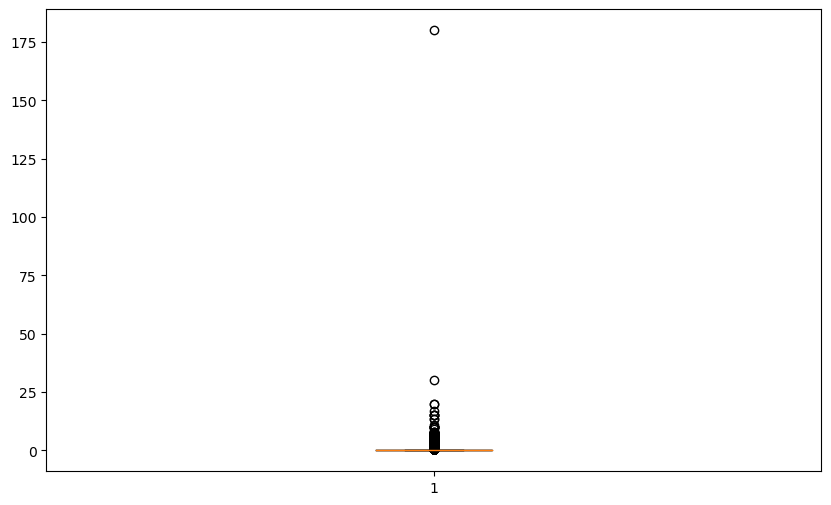

In [65]:
# Viewing outliers for Pallet_per_line.
# Descriptive statistics identifies other columns with potential outliers based on 75% and max values.
# However, Pallet_per_product will be mainly used for this analysis. 
# Outliers in other columns not seen as an issue. 

# Create a boxplot to visualise the outliers. 
plt.figure(figsize=(10, 6))
plt.boxplot(orders_details['Pallet_per_line'])

# Displaying the plot
plt.show()

The chart shows one significant outlier in the data set. Next, we need to identify the outlier.

In [66]:
# Determining the biggest outlier 
q1 = orders_details['Pallet_per_line'].quantile(0.25)
q3 = orders_details['Pallet_per_line'].quantile(0.75)

# Calculating the IQR
iqr = q3 - q1

# Calculating the upper threshold
upper_threshold = q3 + iqr

# Identifying the highest outlier
highest_outlier = orders_details['Pallet_per_line'][orders_details['Pallet_per_line'] > \
                                                    upper_threshold].max()

# Displaying the highest outlier
print("Highest outlier for 'Pallet_per_line':", highest_outlier)

Highest outlier for 'Pallet_per_line': 180.0


The outlier has now been identified and can be removed from the data set. If it is not representative of the orders typically delivered then it should not be included in the fleet and freight analysis as it may skew insights and lead to inaccurate conclusions.

#### Remove outlier from Pallet_per_line

In [67]:
# Removing outliers from Pallet_per_line with value of 180
orders_details = orders_details.drop(
                     orders_details[orders_details[
                         'Pallet_per_line'] == 180].index)

Check that the outlier has indeed been removed by viewing the data set using a boxplot.

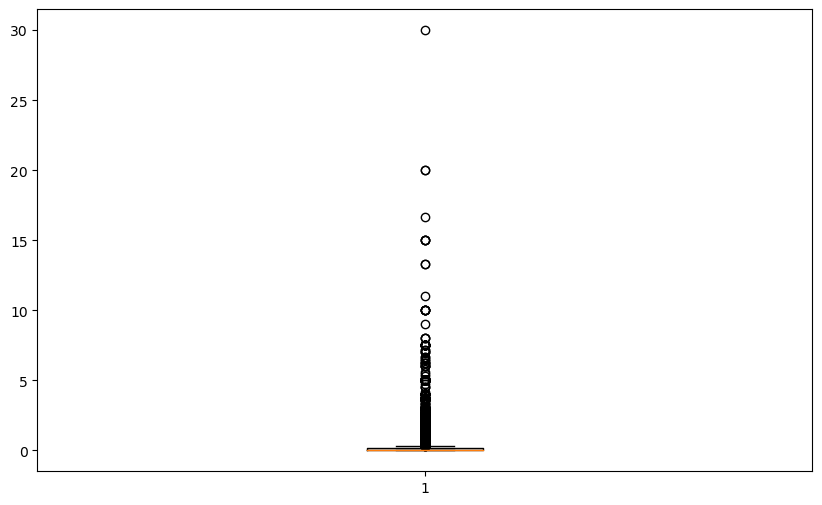

In [68]:
# Creating a boxplot with outlier removed 
plt.figure(figsize=(10, 6))
plt.boxplot(orders_details['Pallet_per_line'])

# Displaying the plot
plt.show()

The boxplot shows that the outlier has now been removed.

In [69]:
# Checking the metadata 
orders_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59942 entries, 0 to 60817
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OrderID             59942 non-null  int64  
 1   PartNumber          59942 non-null  object 
 2   Description         59942 non-null  object 
 3   Packs               59942 non-null  int64  
 4   PackPrice           59942 non-null  float64
 5   UnitsPerPack        59942 non-null  int64  
 6   PackWeight          59942 non-null  float64
 7   LineWeight          59942 non-null  float64
 8   PalletQuantity      59942 non-null  int64  
 9   CubicMPerUnit       59942 non-null  float64
 10  Pallet_per_line     59942 non-null  float64
 11  Volume_per_line_m3  59942 non-null  float64
dtypes: float64(6), int64(4), object(2)
memory usage: 5.9+ MB


#### Rename columns

Some of the column names can be simplified and clarified.

In [70]:
# Renaming column names
orders_details.rename(columns={'PartNumber': 'Part_number',
                               'PackPrice': 'Price_per_pack', 
                               'UnitsPerPack': 'Units_per_pack',
                               'PackWeight': 'Weight_per_pack',
                               'LineWeight': 'Weight_per_line',
                               'PalletQuantity': 'Units_per_pallet',
                               'CubicMPerUnit': 'Volume_per_unit'}, inplace=True)

# Checking this has worked
orders_details.head()

,OrderID,Part_number,Description,Packs,Price_per_pack,Units_per_pack,Weight_per_pack,Weight_per_line,Units_per_pallet,Volume_per_unit,Pallet_per_line,Volume_per_line_m3
0,2275137,CDW241818M,Double wall boxes - 24x18x18 inches (610x457x4...,1,52.44,20,20.98,20.98,140,0.009683,0.142857,0.193660
1,2275137,CSW090606M-P30,Single wall cardboard boxes - 9x6x6 inches (22...,1,7.20,30,2.11,2.11,3600,0.000435,0.008333,0.013050
2,2275137,CSW120909M,Single wall cardboard boxes - 12x9x9 inches (3...,1,10.38,30,5.04,5.04,1800,0.000910,0.016667,0.027300
3,2275137,CSW120906M-P30,Single wall cardboard boxes - 12x9x6 inches (3...,1,8.08,25,3.65,3.65,2100,0.000911,0.011905,0.022775
4,2275137,CDW181212M,Double wall boxes - 18x12x12 inches (457x305x3...,1,24.95,20,9.02,9.02,560,0.004687,0.035714,0.093740


#### Changing Data Types

In [71]:
# Converting OrderID to string data type
orders_details['OrderID'] = orders_details['OrderID'].astype(str)

# Checking this has worked
orders_details.dtypes

OrderID                object
Part_number            object
Description            object
Packs                   int64
Price_per_pack        float64
Units_per_pack          int64
Weight_per_pack       float64
Weight_per_line       float64
Units_per_pallet        int64
Volume_per_unit       float64
Pallet_per_line       float64
Volume_per_line_m3    float64
dtype: object

The order_details DataFrame is now clean. 

# 

##  Orders Sheet

**'Orders' sheet data cleaning methodology:**
1. We renamed some columns to simplify them - 'StatusName': 'OrderStatus', 'PaymentOptionName': 'PaymentOption', 'DespatchedCourier': 'Courier'. We converted the format of the dates to d/m/y to be consistent across the data set.
<br>

2. We removed all rows with an order status of 'Deleted'.
<br>
3. We identified null values in the DeliveryCost and DateDespatched columns. We removed all null values in the DelieveryCost column. We replaced the null values in the DateDespatched column with 24th April 2023 when the order status was 'Dispatched', otherwise we removed the null values. 
<br>
4. We checked and found no duplicates. 
<br>
5. We checked for outliers in the order value and delivery costs - there are outliers, but we felt we should keep them as they are valid data points, and probably represent some very large orders.
<br>
6. We checked the figures in the subtotal and grandtotal columns by performing the calculations (based on the metadata) and found a few figures that appear to be erroneous. 

**Summary of initial findings:**
1. Seasonality in orders placed/despatched: number of orders placed and despatch goes down from Monday to Friday. Very few orders during weekends. 
<br>

2. The majority of orders are despatched on the same day the order comes in. Some orders took as long as 24 days to be despatched however. This is obviously not ideal and should be investigated. Was a delayed payment from the customer something to do with this? Perhaps a certain courier was to blame?
<br>
3. There are some exceptionally high delivery costs and order values that are worth further investigation. 

In [72]:
# Decrypting the Excel file to open it in Python
# Looking at the Orders sheet
file_name = "kite_orders_data.xlsx"
sheet_name = "Orders"
password = "FRMay23" 

with open(file_name, "rb") as file:
    decryptor = msoffcrypto.OfficeFile(file)
    decryptor.load_key(password=password)

    decrypted_data = io.BytesIO()
    decryptor.decrypt(decrypted_data)
    decrypted_data.seek(0)

    # Storing the sheet in a Pandas DataFrame called orders_df
    orders_df = pd.read_excel(decrypted_data, sheet_name=sheet_name,
                              engine='openpyxl')

In [73]:
# Viewing the data to ensure the file has been succesfully imported 
orders_df.head()

,OrderID,WebsiteID,OrderDate,StatusName,StatusId,PaymentOptionName,PaymentType,DespatchedCourier,ProductsExVAT,DeliveryExVAT,VAT,SubTotal,GrandTotal,DateDespatched,DeliveryCost
0,2275137,852084,2023-03-27 00:04:48.773,Dispatched,6,Paypal,1,DX Freight,103.05,0.00,20.62,103.05,123.67,2023-03-27,19.17
1,2275138,673961,2023-03-27 00:21:12.657,Dispatched,6,On Account,3,MFS,480.86,0.00,96.18,480.86,577.04,2023-03-27,76.73
2,2275139,679319,2023-03-27 00:22:25.530,Dispatched,6,Payment Gateway,2,DX Freight,125.28,0.00,25.05,125.28,150.33,2023-03-27,22.67
3,2275140,819078,2023-03-27 00:54:04.783,Dispatched,6,Paypal,1,DX Express,21.26,7.22,5.69,21.26,34.17,2023-03-27,6.81
4,2275141,692729,2023-03-27 00:56:08.917,Dispatched,6,Paypal,1,DX Express,127.88,0.00,25.57,127.88,153.45,2023-03-27,11.19


Data is succesfully imported, we may begin the cleaning process.

In [74]:
# Determining the shape of the data set and the data types 
print(orders_df.shape)
print(orders_df.dtypes)

(24385, 15)
OrderID                       int64
WebsiteID                     int64
OrderDate            datetime64[ns]
StatusName                   object
StatusId                      int64
PaymentOptionName            object
PaymentType                   int64
DespatchedCourier            object
ProductsExVAT               float64
DeliveryExVAT               float64
VAT                         float64
SubTotal                    float64
GrandTotal                  float64
DateDespatched       datetime64[ns]
DeliveryCost                float64
dtype: object


In [75]:
# Simplifying selected column names
orders_df.rename(columns={'StatusName': 'Status',
                          'PaymentOptionName': 'PaymentOption', 
                          'DespatchedCourier': 'Courier'}, inplace=True)

# Converting the formats of the two dates
orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'],
                                        format='%d/%m/%Y')
orders_df['DateDespatched'] = pd.to_datetime(orders_df['DateDespatched'],
                                             format='%d/%m/%Y')

# Checking this has worked
print(orders_df.head())
orders_df.dtypes

   OrderID  WebsiteID               OrderDate      Status  StatusId  \
0  2275137     852084 2023-03-27 00:04:48.773  Dispatched         6   
1  2275138     673961 2023-03-27 00:21:12.657  Dispatched         6   
2  2275139     679319 2023-03-27 00:22:25.530  Dispatched         6   
3  2275140     819078 2023-03-27 00:54:04.783  Dispatched         6   
4  2275141     692729 2023-03-27 00:56:08.917  Dispatched         6   

     PaymentOption  PaymentType     Courier  ProductsExVAT  DeliveryExVAT  \
0           Paypal            1  DX Freight         103.05           0.00   
1       On Account            3         MFS         480.86           0.00   
2  Payment Gateway            2  DX Freight         125.28           0.00   
3           Paypal            1  DX Express          21.26           7.22   
4           Paypal            1  DX Express         127.88           0.00   

     VAT  SubTotal  GrandTotal DateDespatched  DeliveryCost  
0  20.62    103.05      123.67     2023-03-27   

OrderID                    int64
WebsiteID                  int64
OrderDate         datetime64[ns]
Status                    object
StatusId                   int64
PaymentOption             object
PaymentType                int64
Courier                   object
ProductsExVAT            float64
DeliveryExVAT            float64
VAT                      float64
SubTotal                 float64
GrandTotal               float64
DateDespatched    datetime64[ns]
DeliveryCost             float64
dtype: object

In [76]:
# Check for duplicates in the dataset 
orders_df.duplicated().sum()

0

In [77]:
# Inspecting the categorical varaibles
print(orders_df['Status'].unique())
print(orders_df['PaymentOption'].unique())
print(orders_df['Courier'].unique())

['Dispatched' 'Deleted' 'Proforma Unpaid' 'Processing'
 'Prepay Payment Pending']
['Paypal' 'On Account' 'Payment Gateway' 'Sample'
 'Cheque, BACS or pro-forma']
['DX Freight' 'MFS' 'DX Express' 'Split' 'Direct']


Here, we can see that Deleted is an option for the order status. Let's remove these orders from the data set.

In [78]:
# Removing rows with Status 'Deleted'
orders_df = orders_df[~orders_df['Status'].str.contains('Deleted')]

# Checking this has worked
orders_df['Status'].unique()

array(['Dispatched', 'Proforma Unpaid', 'Processing',
       'Prepay Payment Pending'], dtype=object)

In [79]:
# Checking whether there are any null values 
orders_df.isnull().sum()

OrderID             0
WebsiteID           0
OrderDate           0
Status              0
StatusId            0
PaymentOption       0
PaymentType         0
Courier             0
ProductsExVAT       0
DeliveryExVAT       0
VAT                 0
SubTotal            0
GrandTotal          0
DateDespatched    306
DeliveryCost      120
dtype: int64

In [80]:
# Remove rows with null values in 'DeliveryCost'
orders_df = orders_df.dropna(subset = ['DeliveryCost'])

# Checking this has worked
orders_df.isnull().sum()

OrderID             0
WebsiteID           0
OrderDate           0
Status              0
StatusId            0
PaymentOption       0
PaymentType         0
Courier             0
ProductsExVAT       0
DeliveryExVAT       0
VAT                 0
SubTotal            0
GrandTotal          0
DateDespatched    186
DeliveryCost        0
dtype: int64

In [81]:
# Identifying the status of these orders with null values in DateDespatched
orders_df[orders_df['DateDespatched'].isnull()]['Status'].unique()

array(['Processing', 'Dispatched'], dtype=object)

In [82]:
# Removing the rows with status 'Processing' and null values in DateDespatched
orders_df = orders_df[~((orders_df['DateDespatched'].isnull()) & \
                        (orders_df['Status'] == 'Processing'))]

# Checking this has worked
orders_df[orders_df['DateDespatched'].isnull()]['Status'].unique()

array(['Dispatched'], dtype=object)

In [83]:
# Checking again if there are any more null values 
orders_df.isnull().sum()

OrderID           0
WebsiteID         0
OrderDate         0
Status            0
StatusId          0
PaymentOption     0
PaymentType       0
Courier           0
ProductsExVAT     0
DeliveryExVAT     0
VAT               0
SubTotal          0
GrandTotal        0
DateDespatched    5
DeliveryCost      0
dtype: int64

Here, we can see that there are 5 null values still in the DateDespatched column. Having spoken to Kite, we understand these should be 24th April 2023. 

In [84]:
# Replacing the remaining null values with 24th April 2023
orders_df['DateDespatched'].fillna(dt.datetime(2023, 4, 24), inplace = True)

# Checking for the number of null values now
orders_df.isnull().sum()

OrderID           0
WebsiteID         0
OrderDate         0
Status            0
StatusId          0
PaymentOption     0
PaymentType       0
Courier           0
ProductsExVAT     0
DeliveryExVAT     0
VAT               0
SubTotal          0
GrandTotal        0
DateDespatched    0
DeliveryCost      0
dtype: int64

In [85]:
# Checking the data types of the cleaned data set
print(orders_df.dtypes)

# Checking the new shape of the cleaned data set
print("Cleaned dataset shape:", orders_df.shape)

OrderID                    int64
WebsiteID                  int64
OrderDate         datetime64[ns]
Status                    object
StatusId                   int64
PaymentOption             object
PaymentType                int64
Courier                   object
ProductsExVAT            float64
DeliveryExVAT            float64
VAT                      float64
SubTotal                 float64
GrandTotal               float64
DateDespatched    datetime64[ns]
DeliveryCost             float64
dtype: object
Cleaned dataset shape: (23414, 15)


In [86]:
# Converting OrderID and WebsiteID to string
orders_df['OrderID'] = orders_df['OrderID'].astype(str)
orders_df['WebsiteID'] = orders_df['WebsiteID'].astype(str)

# Checking this has worked
orders_df.dtypes

OrderID                   object
WebsiteID                 object
OrderDate         datetime64[ns]
Status                    object
StatusId                   int64
PaymentOption             object
PaymentType                int64
Courier                   object
ProductsExVAT            float64
DeliveryExVAT            float64
VAT                      float64
SubTotal                 float64
GrandTotal               float64
DateDespatched    datetime64[ns]
DeliveryCost             float64
dtype: object

In [87]:
# Giving the cleaned data set a more appropriate name
orders_cleaned = orders_df

# Viewing this DataFrame
orders_cleaned.head()

,OrderID,WebsiteID,OrderDate,Status,StatusId,PaymentOption,PaymentType,Courier,ProductsExVAT,DeliveryExVAT,VAT,SubTotal,GrandTotal,DateDespatched,DeliveryCost
0,2275137,852084,2023-03-27 00:04:48.773,Dispatched,6,Paypal,1,DX Freight,103.05,0.00,20.62,103.05,123.67,2023-03-27,19.17
1,2275138,673961,2023-03-27 00:21:12.657,Dispatched,6,On Account,3,MFS,480.86,0.00,96.18,480.86,577.04,2023-03-27,76.73
2,2275139,679319,2023-03-27 00:22:25.530,Dispatched,6,Payment Gateway,2,DX Freight,125.28,0.00,25.05,125.28,150.33,2023-03-27,22.67
3,2275140,819078,2023-03-27 00:54:04.783,Dispatched,6,Paypal,1,DX Express,21.26,7.22,5.69,21.26,34.17,2023-03-27,6.81
4,2275141,692729,2023-03-27 00:56:08.917,Dispatched,6,Paypal,1,DX Express,127.88,0.00,25.57,127.88,153.45,2023-03-27,11.19


Now we have cleaned the data, we may perform some inital analysis.

### Inspecting DateDespatched 


In [88]:
# Determining the minimum and maximum dates in DateDespatched
print("Orders were despatched between", orders_cleaned['DateDespatched'].min(), "and",
      orders_cleaned['DateDespatched'].max())

Orders were despatched between 2023-03-27 00:00:00 and 2023-04-24 00:00:00


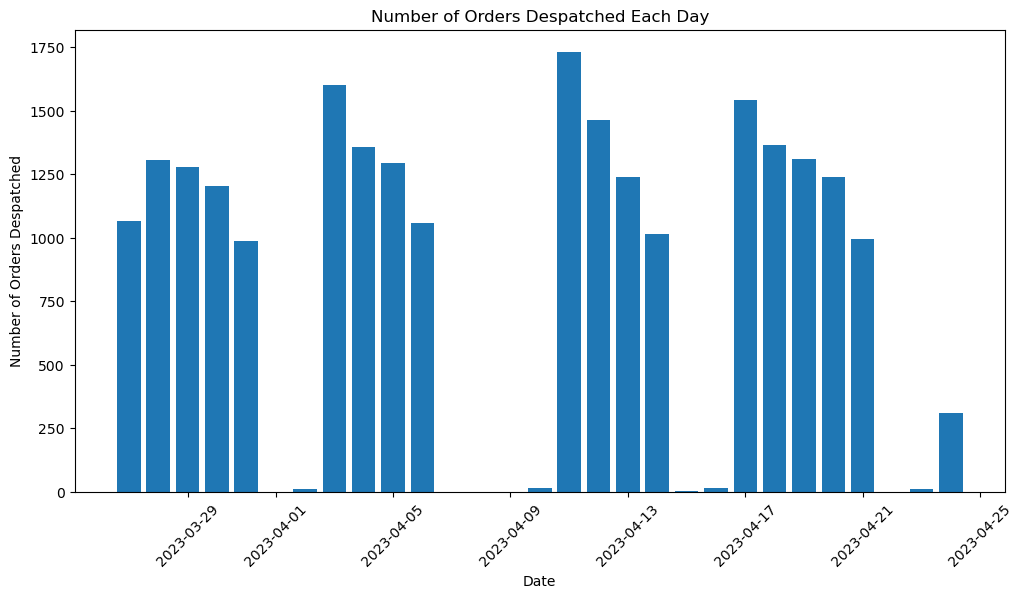

In [89]:
# Visualise orders despatched by date 

# Counting the number of orders despatched each day
daily_orders = orders_cleaned['DateDespatched'].value_counts().sort_index()
daily_orders.index = pd.to_datetime(daily_orders.index)
daily_orders = daily_orders.sort_index(ascending=True)

# Creating a bar plot to visualise any pattern in orders
plt.figure(figsize=(12, 6))
plt.bar(daily_orders.index, daily_orders)
plt.xlabel('Date')
plt.ylabel('Number of Orders Despatched')
plt.title('Number of Orders Despatched Each Day')
plt.xticks(rotation=45)
plt.show()

It appears that there is seasonality in the number of orders despatched per day. There are almost no orders being despatched on weekends and bank holidays.

In [90]:
# Checking warehouse efficiency  - measured by the days taken between from order to despatch
# Create a column to store days taken between an order being made and being despatched
orders_cleaned['OrderedDespatched'] = (orders_cleaned['DateDespatched'].dt.date 
                                       - orders_cleaned['OrderDate'].dt.date)

# Convert this to just a number
orders_cleaned['OrderedDespatched'] = orders_cleaned['OrderedDespatched'].dt.days

# Checking if this has worked
print(orders_cleaned['OrderedDespatched'].head())

0    0
1    0
2    0
3    0
4    0
Name: OrderedDespatched, dtype: int64


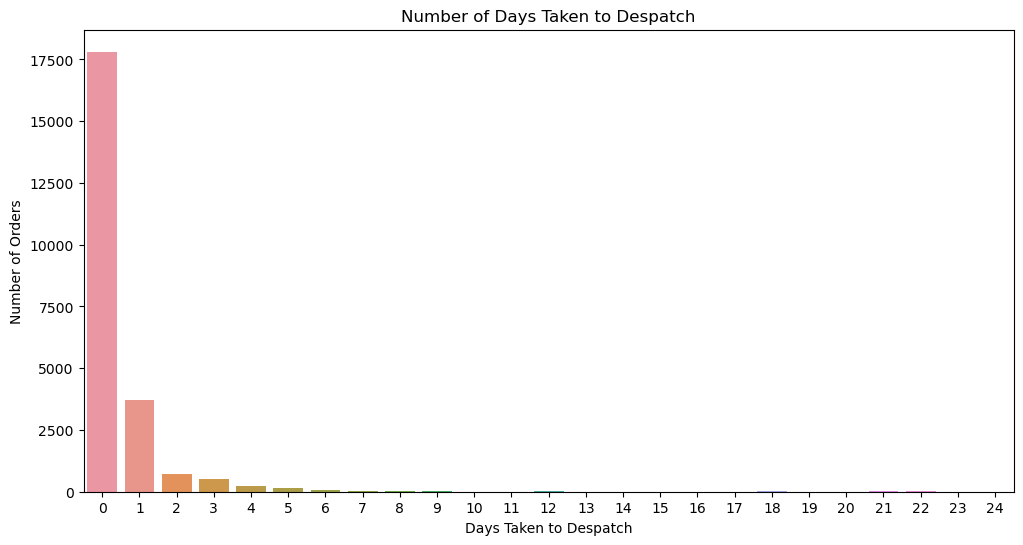

In [91]:
# Create a countplot to show the number of orders for each number of days taken to despatch
plt.figure(figsize=(12, 6))
sns.countplot(x='OrderedDespatched', data=orders_cleaned)
plt.xlabel('Days Taken to Despatch')
plt.ylabel('Number of Orders')
plt.title('Number of Days Taken to Despatch')
plt.show()

The majority of orders took 0 days to be despatched ie. same-day-delivery. Some orders took as long as 24 days to be despatched however. This is obviously not ideal and should be investigated. Was a delayed payment from the customer something to do with this? Perhaps a certain courier was to blame?

### Inspecting OrderID and WebsiteID 


In [92]:
# Checking the number of orders in this data set
print("The number of orders in this data set is: ",
      len(orders_cleaned['OrderID'].unique()))

# Checking the number of customers in this data set
print("The number of customers in this data set is: ",
      len(orders_cleaned['WebsiteID'].unique()))

The number of orders in this data set is:  23414
The number of customers in this data set is:  18440


This tells us that some customers have ordered more than once.

### Inspecting OrderDate

In [93]:
# Determining the minimum and maximum dates in the orders_cleaned DataFrame 
print("Orders were scheduled between", orders_cleaned['OrderDate'].min(),
      "and",orders_cleaned['OrderDate'].max())

Orders were scheduled between 2023-03-27 00:04:48.773000 and 2023-04-22 23:56:53.570000


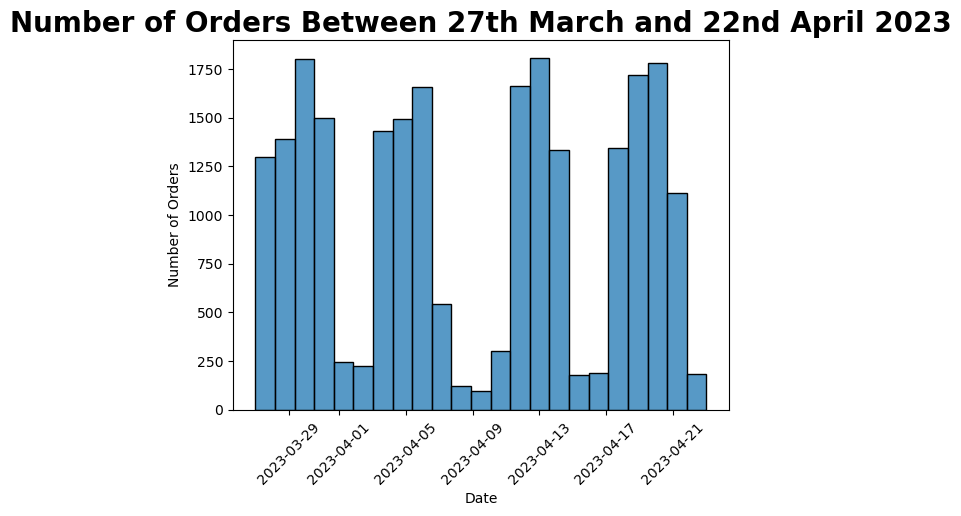

In [94]:
# Creating a histogram to show the number of orders each day
ax = sns.histplot(orders_cleaned['OrderDate'])

# Adding axes labels to the plot
ax.set(xlabel = 'Date', 
       ylabel = 'Number of Orders')

# Adding a title to the plot
# Making the title bold and increasing the font size
plt.title('Number of Orders Between 27th March and 22nd April 2023', 
          weight = 'bold')\
.set_fontsize('20')

# Rotating the labels on the x-axis to make them more readable
plt.xticks(rotation = 45)

# Showing the plot
plt.show(ax)

It appears that there is some seasonality in the number of orders per day. There definitely seems to be less orders during the weekend. The unusually low number of orders on the 7th and 10th of April correspond to the UK Easter bank holidays.

### Inspecting Courier 

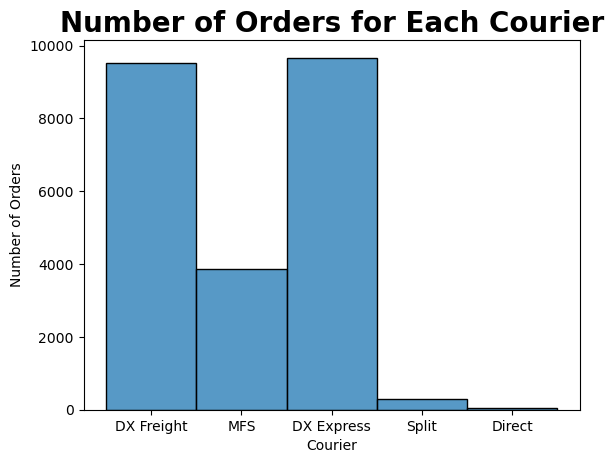

In [95]:
# Creating a histplot to show the number of orders for each courier
ax = sns.histplot(orders_cleaned['Courier'])

# Adding axes labels to the plot
ax.set(xlabel = 'Courier', 
       ylabel = 'Number of Orders')

# Adding a title to the plot
# Making the title bold and increasing the font size
plt.title('Number of Orders for Each Courier', 
          weight = 'bold')\
.set_fontsize('20')

# Showing the plot
plt.show(ax)

DX Freight and DX Express Courier are the top two couriers by number of orders. 

### Inspecting the Distribution of ProductsExVAT and DeliveryCost

In [96]:
# Looking at the descriptive statistics for ProductsExVAT
orders_cleaned['ProductsExVAT'].describe()

count    23414.000000
mean       229.175505
std        370.685601
min          0.000000
25%         57.450000
50%        125.110000
75%        253.797500
max      11450.400000
Name: ProductsExVAT, dtype: float64

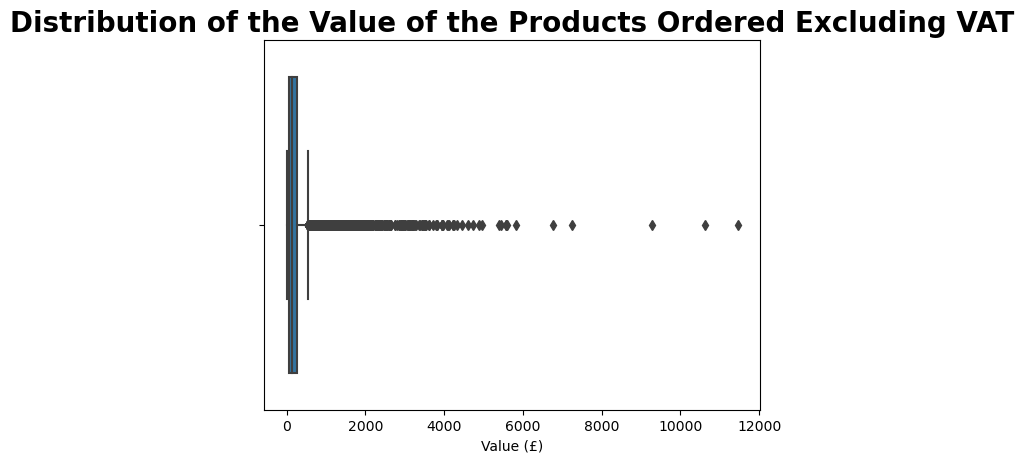

In [97]:
# Creating a boxplot to show the distribution of ProductsExVAT
ax = sns.boxplot(x = orders_cleaned['ProductsExVAT'])

# Adding axes labels to the plot
ax.set(xlabel = 'Value (£)')

# Adding a title to the plot
# Making the title bold and increasing the font size
plt.title('Distribution of the Value of the Products Ordered Excluding VAT', 
          weight = 'bold')\
.set_fontsize('20')

# Showing the plot
plt.show(ax)

Lots of outliers of the products ordered excluding VAT. We decided not to delete these as they represent valid orders that just have a high value. 

In [98]:
# Looking at the descriptive statistics for DeliveryCost
orders_cleaned['DeliveryCost'].describe()

count    23414.000000
mean        24.954456
std         38.174166
min          0.000000
25%          6.800000
50%         13.020000
75%         31.210000
max       1297.270000
Name: DeliveryCost, dtype: float64

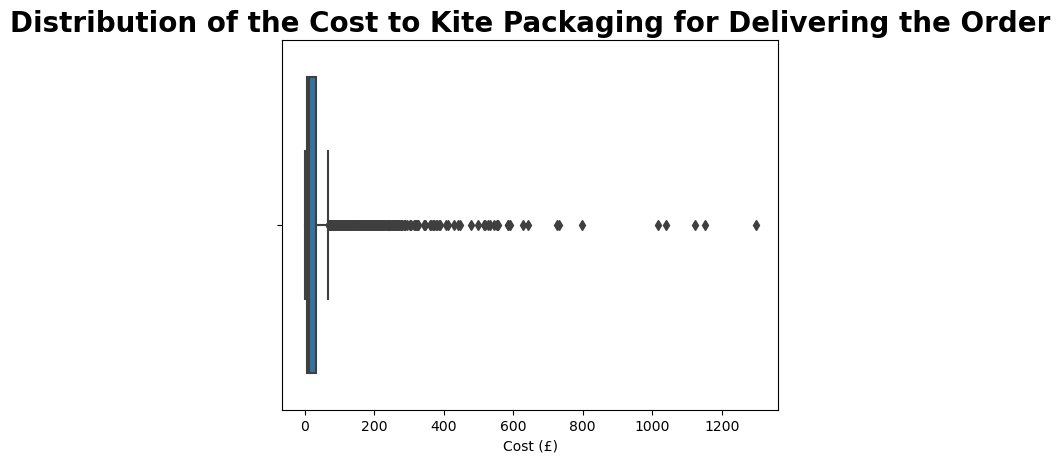

In [99]:
# Creating a boxplot to show the distribution of DeliveryCost
ax = sns.boxplot(x = orders_cleaned['DeliveryCost'])

# Adding axes labels to the plot
ax.set(xlabel = 'Cost (£)')

# Adding a title to the plot
# Making the title bold and increasing the font size
plt.title('Distribution of the Cost to Kite Packaging for Delivering the Order', 
          weight = 'bold')\
.set_fontsize('20')

# Showing the plot
plt.show(ax)

There are many outliers. These outliers represent valid data points so we may need to keep them. We may transform the data in future analysis.

### Inspecting SubTotal

In [100]:
# Creating a variable to store the calculated sub totals according to the metadata:
# SubTotal = ProductsExVAT + DeliveryExVAT
SubTotalTest = orders_cleaned['ProductsExVAT'] + orders_cleaned['DeliveryExVAT']

# Checking that this has worked
SubTotalTest.head()

0    103.05
1    480.86
2    125.28
3     28.48
4    127.88
dtype: float64

In [101]:
# Creating a column to indicate whether there has been an error in calculating the sub total
orders_cleaned['SubTotalError'] = (SubTotalTest - 
                                   orders_cleaned['SubTotal']) != 0

# Viewing the rows where there has been an error 
orders_cleaned[orders_cleaned['SubTotalError'] == True]

,OrderID,WebsiteID,OrderDate,Status,StatusId,PaymentOption,PaymentType,Courier,ProductsExVAT,DeliveryExVAT,VAT,SubTotal,GrandTotal,DateDespatched,DeliveryCost,OrderedDespatched,SubTotalError
3,2275140,819078,2023-03-27 00:54:04.783,Dispatched,6,Paypal,1,DX Express,21.26,7.22,5.69,21.26,34.17,2023-03-27,6.81,0,True
6,2275143,809450,2023-03-27 01:45:13.837,Dispatched,6,Payment Gateway,2,DX Express,179.67,19.99,39.94,179.67,239.60,2023-03-27,10.25,0,True
8,2275145,897079,2023-03-27 02:08:32.563,Dispatched,6,Paypal,1,DX Express,35.08,7.22,8.46,35.08,50.76,2023-03-27,6.81,0,True
9,2275146,897080,2023-03-27 02:16:47.437,Dispatched,6,Payment Gateway,2,DX Express,18.36,7.22,5.11,18.36,30.69,2023-03-27,6.81,0,True
11,2275148,897081,2023-03-27 03:05:24.317,Dispatched,6,Payment Gateway,2,DX Freight,39.22,15.51,10.94,39.22,65.67,2023-03-27,13.85,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24378,2299515,772392,2023-04-22 22:05:58.720,Dispatched,6,Payment Gateway,2,DX Express,28.35,7.17,7.10,28.35,42.62,2023-04-24,6.76,2,True
24379,2299516,807311,2023-04-22 22:41:25.630,Dispatched,6,Paypal,1,DX Express,94.12,7.17,20.25,94.12,121.54,2023-04-24,6.76,2,True
24380,2299517,901729,2023-04-22 22:41:37.903,Dispatched,6,Payment Gateway,2,DX Express,40.54,7.17,9.54,40.54,57.25,2023-04-24,6.76,2,True
24381,2299518,860494,2023-04-22 23:08:00.187,Dispatched,6,Payment Gateway,2,DX Express,48.24,7.17,11.08,48.24,66.49,2023-04-24,6.76,2,True


In [102]:
# Inspect the difference between SubTotalTest and Subtotal 

# Calculate the differences between SubTotalTest and SubTotal
orders_cleaned['SubTotalDifference'] = (SubTotalTest 
                                        - orders_cleaned['SubTotal'])

# Explore the distribution of differences
print(orders_cleaned['SubTotalDifference'].describe())

count    23414.000000
mean         4.899322
std          9.409058
min          0.000000
25%          0.000000
50%          0.000000
75%          7.210000
max        662.460000
Name: SubTotalDifference, dtype: float64


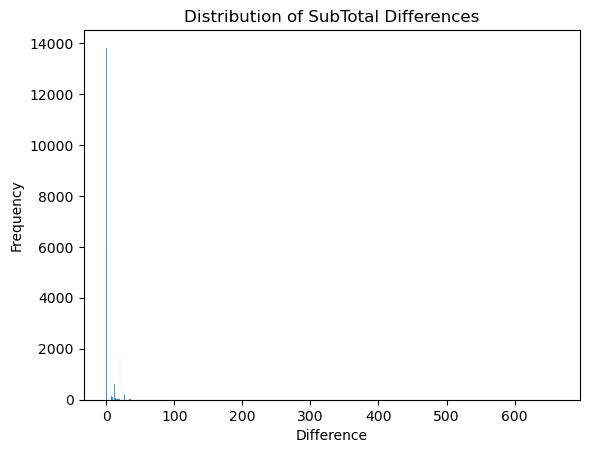

In [103]:
# Visualise the distribution of differences using a histogram
sns.histplot(orders_cleaned['SubTotalDifference'])
plt.title('Distribution of SubTotal Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

Looks like there is a mean difference of  4.893510 - these are most likely rounding errors or just minor data entry errors. 

### Inspecting GrandTotal


In [104]:
# Creating a variable to store the calculated grand totals according to the metadata:
# GrandTotal = ProductsExVAT + DeliveryExVAT + VAT
GrandTotalTest = (orders_cleaned['ProductsExVAT'] 
                  + orders_cleaned['DeliveryExVAT'] 
                  + orders_cleaned['VAT'])

# Checking that this has worked
GrandTotalTest.head()

0    123.67
1    577.04
2    150.33
3     34.17
4    153.45
dtype: float64

In [105]:
# Creating a column to indicate whether there has been an error in calculating the grand total
orders_cleaned['GrandTotalError'] = (GrandTotalTest 
                                     - orders_cleaned['GrandTotal'] != 0)

# Viewing the rows where there has been an error 
orders_cleaned[orders_cleaned['GrandTotalError'] == True]

,OrderID,WebsiteID,OrderDate,Status,StatusId,PaymentOption,PaymentType,Courier,ProductsExVAT,DeliveryExVAT,VAT,SubTotal,GrandTotal,DateDespatched,DeliveryCost,OrderedDespatched,SubTotalError,SubTotalDifference,GrandTotalError
5,2275142,709988,2023-03-27 01:28:45.690,Dispatched,6,Payment Gateway,2,DX Freight,107.62,0.00,21.52,107.62,129.14,2023-03-27,15.80,0,False,0.00,True
9,2275146,897080,2023-03-27 02:16:47.437,Dispatched,6,Payment Gateway,2,DX Express,18.36,7.22,5.11,18.36,30.69,2023-03-27,6.81,0,True,7.22,True
12,2275149,852914,2023-03-27 05:50:28.027,Dispatched,6,Payment Gateway,2,DX Express,40.78,7.23,9.61,40.78,57.62,2023-03-27,6.81,0,True,7.23,True
13,2275150,826472,2023-03-27 05:53:36.000,Dispatched,6,Payment Gateway,2,DX Freight,164.88,0.00,32.98,164.88,197.86,2023-03-27,26.16,0,False,0.00,True
14,2275151,693017,2023-03-27 06:24:06.597,Dispatched,6,Payment Gateway,2,DX Freight,206.45,0.00,41.29,206.45,247.74,2023-03-27,31.60,0,False,0.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24377,2299514,736532,2023-04-22 21:54:37.273,Dispatched,6,Payment Gateway,2,DX Freight,87.40,39.56,25.39,87.40,152.35,2023-04-24,17.47,2,True,39.56,True
24378,2299515,772392,2023-04-22 22:05:58.720,Dispatched,6,Payment Gateway,2,DX Express,28.35,7.17,7.10,28.35,42.62,2023-04-24,6.76,2,True,7.17,True
24381,2299518,860494,2023-04-22 23:08:00.187,Dispatched,6,Payment Gateway,2,DX Express,48.24,7.17,11.08,48.24,66.49,2023-04-24,6.76,2,True,7.17,True
24382,2299519,890264,2023-04-22 23:11:00.150,Dispatched,6,Payment Gateway,2,DX Express,49.35,7.17,11.30,49.35,67.82,2023-04-24,6.76,2,True,7.17,True


In [106]:
# Lets explore the difference between the calculated and given grand totals 

# Creating a column to store the differences between the calculated and given GrandTotal
orders_cleaned['GrandTotalDifference'] = (GrandTotalTest 
                                          - orders_cleaned['GrandTotal'])

# Explore the distribution of differences
print(orders_cleaned['GrandTotalDifference'].describe())


count    2.341400e+04
mean     5.536658e-01
std      1.090590e+01
min     -9.094947e-13
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.282000e+02
Name: GrandTotalDifference, dtype: float64


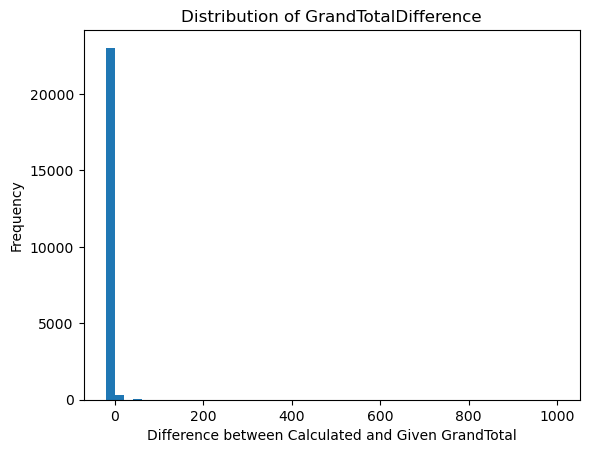

In [107]:
# Visualise the difference with a histogram 

plt.hist(orders_cleaned['GrandTotalDifference'], bins=50, range=(-20, 1000))
plt.xlabel('Difference between Calculated and Given GrandTotal')
plt.ylabel('Frequency')
plt.title('Distribution of GrandTotalDifference')
plt.show()

The majority of the data is not that different hence the low mean, therefore it is likely that the discrepancy is caused by minor rounding errors. The Sheets are all now clean and ready to be joined. 


# 

## Joining the Cleaned DataFrames

Our first stage is to join the orders_cleaned, customers_cleaned, and orders_details DataFrames. This will give us a master joined data set to work with 

In [108]:
# Merging the orders_cleaned and customers_cleaned DataFrames
orders_customers = pd.merge(orders_cleaned, customers_cleaned,
                            left_on = 'WebsiteID',
                            right_on = 'customerID',
                            how = 'inner')
                            
# Viewing this merged DataFrame
orders_customers.head()

,OrderID,WebsiteID,OrderDate,Status,StatusId,PaymentOption,PaymentType,Courier,ProductsExVAT,DeliveryExVAT,...,DateDespatched,DeliveryCost,OrderedDespatched,SubTotalError,SubTotalDifference,GrandTotalError,GrandTotalDifference,customerID,country,outward_code
0,2275137,852084,2023-03-27 00:04:48.773,Dispatched,6,Paypal,1,DX Freight,103.05,0.00,...,2023-03-27,19.17,0,False,0.00,False,0.000000e+00,852084,United Kingdom,CA2
1,2284674,852084,2023-04-04 22:40:19.970,Dispatched,6,Payment Gateway,2,DX Express,114.99,0.00,...,2023-04-05,8.04,1,False,0.00,False,0.000000e+00,852084,United Kingdom,CA2
2,2275138,673961,2023-03-27 00:21:12.657,Dispatched,6,On Account,3,MFS,480.86,0.00,...,2023-03-27,76.73,0,False,0.00,False,0.000000e+00,673961,United Kingdom,M8
3,2284238,673961,2023-04-04 14:49:32.570,Dispatched,6,On Account,3,MFS,539.84,19.99,...,2023-04-04,83.60,0,True,19.99,True,1.136868e-13,673961,United Kingdom,M8
4,2275139,679319,2023-03-27 00:22:25.530,Dispatched,6,Payment Gateway,2,DX Freight,125.28,0.00,...,2023-03-27,22.67,0,False,0.00,False,0.000000e+00,679319,United Kingdom,SK8


In [109]:
# Removing unnecessary columns from the merged DataFrame
orders_customers.drop(['StatusId','PaymentType','customerID',
                       'VAT','SubTotal','GrandTotal',
                       'SubTotalError','SubTotalDifference',
                       'GrandTotalError','GrandTotalDifference',
                       'OrderedDespatched'], axis = 1, inplace = True)

# Checking this has worked
orders_customers.head()

,OrderID,WebsiteID,OrderDate,Status,PaymentOption,Courier,ProductsExVAT,DeliveryExVAT,DateDespatched,DeliveryCost,country,outward_code
0,2275137,852084,2023-03-27 00:04:48.773,Dispatched,Paypal,DX Freight,103.05,0.00,2023-03-27,19.17,United Kingdom,CA2
1,2284674,852084,2023-04-04 22:40:19.970,Dispatched,Payment Gateway,DX Express,114.99,0.00,2023-04-05,8.04,United Kingdom,CA2
2,2275138,673961,2023-03-27 00:21:12.657,Dispatched,On Account,MFS,480.86,0.00,2023-03-27,76.73,United Kingdom,M8
3,2284238,673961,2023-04-04 14:49:32.570,Dispatched,On Account,MFS,539.84,19.99,2023-04-04,83.60,United Kingdom,M8
4,2275139,679319,2023-03-27 00:22:25.530,Dispatched,Payment Gateway,DX Freight,125.28,0.00,2023-03-27,22.67,United Kingdom,SK8


In [110]:
# Grouping the orders_details DataFrame by OrderID
grouped = orders_details.groupby('OrderID')['Weight_per_line',
                                            'Volume_per_line_m3',
                                            'Pallet_per_line'].sum()

C:\Users\kesha\AppData\Local\Temp\ipykernel_47092\3183058921.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = orders_details.groupby('OrderID')['Weight_per_line',


In [111]:
# Merging the orders_customers and grouped DataFrames
all_joined = pd.merge(orders_customers, grouped,
                      on = 'OrderID',
                      how = 'inner')

# Viewing this merged DataFrame
all_joined.head()

,OrderID,WebsiteID,OrderDate,Status,PaymentOption,Courier,ProductsExVAT,DeliveryExVAT,DateDespatched,DeliveryCost,country,outward_code,Weight_per_line,Volume_per_line_m3,Pallet_per_line
0,2275137,852084,2023-03-27 00:04:48.773,Dispatched,Paypal,DX Freight,103.05,0.00,2023-03-27,19.17,United Kingdom,CA2,40.80,0.350525,0.215476
1,2284674,852084,2023-04-04 22:40:19.970,Dispatched,Payment Gateway,DX Express,114.99,0.00,2023-04-05,8.04,United Kingdom,CA2,23.69,0.094652,0.064633
2,2275138,673961,2023-03-27 00:21:12.657,Dispatched,On Account,MFS,480.86,0.00,2023-03-27,76.73,United Kingdom,M8,172.67,2.080320,1.190000
3,2284238,673961,2023-04-04 14:49:32.570,Dispatched,On Account,MFS,539.84,19.99,2023-04-04,83.60,United Kingdom,M8,318.61,2.761120,2.000000
4,2275139,679319,2023-03-27 00:22:25.530,Dispatched,Payment Gateway,DX Freight,125.28,0.00,2023-03-27,22.67,United Kingdom,SK8,49.92,0.302700,0.241667


In [112]:
# Checking the shape of this DataFrame
all_joined.shape

(22991, 15)

In [113]:
# Exporting the merged data as an XLSX file
all_joined.to_excel('all_joined.xlsx')

Now that we have the master joined data set, we can think about creating a DataFrame with the relevant information for our analysis.

# 

## Data Cleaning of the Joined DataFrame 

### Extracting customers within 50 miles radius of Midlands (Coventry) from  cust_kite_50m

Since the business objective is to reduce courier costs by 20% within the 50-mile radius around Coventry distribution centre, we decided to only look at customers within this area. 

In [114]:
# Filtering the DataFrame to include only customers within 50 miles from Midlands
cust_coventry_50m = cust_kite_50m[cust_kite_50m ['dist_centres'] == 'Midlands' ]

# Viewing this filtered DataFrame
cust_coventry_50m.head()

,outward_code,customerID,dist_centres,distance
56199,DY6,7700,Midlands,26.84
56202,OX18,9759,Midlands,43.04
56212,CV5,13038,Midlands,2.34
56218,WS15,15160,Midlands,29.80
56221,MK1,16152,Midlands,44.21


In [115]:
# Merging the identified customers within 50 mile radius of Coventry to all_joined 
merged_50 = pd.merge(cust_coventry_50m, all_joined,
                     left_on = 'customerID', 
                     right_on = 'WebsiteID', 
                     how = 'inner')

# View this DataFrame
merged_50.head()

,outward_code_x,customerID,dist_centres,distance,OrderID,WebsiteID,OrderDate,Status,PaymentOption,Courier,ProductsExVAT,DeliveryExVAT,DateDespatched,DeliveryCost,country,outward_code_y,Weight_per_line,Volume_per_line_m3,Pallet_per_line
0,DY6,7700,Midlands,26.84,2295440,7700,2023-04-18 15:16:50.030,Dispatched,On Account,MFS,375.40,0.00,2023-04-18,34.46,United Kingdom,DY6,110.00,0.225000,0.200000
1,OX18,9759,Midlands,43.04,2292996,9759,2023-04-16 20:47:47.493,Dispatched,Payment Gateway,DX Freight,148.41,0.00,2023-04-17,14.77,United Kingdom,OX18,29.24,0.219678,0.200025
2,CV5,13038,Midlands,2.34,2285048,13038,2023-04-05 10:58:30.303,Dispatched,Payment Gateway,DX Freight,170.94,0.00,2023-04-05,14.45,United Kingdom,CV5,28.50,0.044060,0.044323
3,WS15,15160,Midlands,29.80,2297608,15160,2023-04-20 11:31:32.320,Dispatched,On Account,DX Express,42.26,7.17,2023-04-20,6.76,United Kingdom,WS15,8.56,0.053674,0.028439
4,MK1,16152,Midlands,44.21,2281052,16152,2023-03-31 14:07:41.883,Dispatched,On Account,DX Freight,124.36,0.00,2023-03-31,22.28,United Kingdom,MK1,48.74,0.090629,0.059524


In [116]:
# Drop irrelevant columns
merged_50.drop(columns =['customerID', 'outward_code_y'], inplace = True)

# Viewing this DataFrame
merged_50.head()

,outward_code_x,dist_centres,distance,OrderID,WebsiteID,OrderDate,Status,PaymentOption,Courier,ProductsExVAT,DeliveryExVAT,DateDespatched,DeliveryCost,country,Weight_per_line,Volume_per_line_m3,Pallet_per_line
0,DY6,Midlands,26.84,2295440,7700,2023-04-18 15:16:50.030,Dispatched,On Account,MFS,375.40,0.00,2023-04-18,34.46,United Kingdom,110.00,0.225000,0.200000
1,OX18,Midlands,43.04,2292996,9759,2023-04-16 20:47:47.493,Dispatched,Payment Gateway,DX Freight,148.41,0.00,2023-04-17,14.77,United Kingdom,29.24,0.219678,0.200025
2,CV5,Midlands,2.34,2285048,13038,2023-04-05 10:58:30.303,Dispatched,Payment Gateway,DX Freight,170.94,0.00,2023-04-05,14.45,United Kingdom,28.50,0.044060,0.044323
3,WS15,Midlands,29.80,2297608,15160,2023-04-20 11:31:32.320,Dispatched,On Account,DX Express,42.26,7.17,2023-04-20,6.76,United Kingdom,8.56,0.053674,0.028439
4,MK1,Midlands,44.21,2281052,16152,2023-03-31 14:07:41.883,Dispatched,On Account,DX Freight,124.36,0.00,2023-03-31,22.28,United Kingdom,48.74,0.090629,0.059524


In [117]:
# Checking the DataFrame
merged_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4126 entries, 0 to 4125
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   outward_code_x      4126 non-null   object        
 1   dist_centres        4126 non-null   object        
 2   distance            4126 non-null   float64       
 3   OrderID             4126 non-null   object        
 4   WebsiteID           4126 non-null   object        
 5   OrderDate           4126 non-null   datetime64[ns]
 6   Status              4126 non-null   object        
 7   PaymentOption       4126 non-null   object        
 8   Courier             4126 non-null   object        
 9   ProductsExVAT       4126 non-null   float64       
 10  DeliveryExVAT       4126 non-null   float64       
 11  DateDespatched      4126 non-null   datetime64[ns]
 12  DeliveryCost        4126 non-null   float64       
 13  country             4126 non-null   object      

#### Removing the 'Direct' Courier from the DataFrame

In [118]:
# List of unique couriers in the DataFrame
merged_50['Courier'].unique()

array(['MFS', 'DX Freight', 'DX Express', 'Split', 'Direct'], dtype=object)

In [119]:
# Filtering merged_50 to exclude the 'Direct' Courier
miles50_coventry = merged_50[merged_50['Courier'].isin({'MFS', 'DX Freight',
                                                        'DX Express', 'Split'})]

# Viewing the DataFrame
miles50_coventry

,outward_code_x,dist_centres,distance,OrderID,WebsiteID,OrderDate,Status,PaymentOption,Courier,ProductsExVAT,DeliveryExVAT,DateDespatched,DeliveryCost,country,Weight_per_line,Volume_per_line_m3,Pallet_per_line
0,DY6,Midlands,26.84,2295440,7700,2023-04-18 15:16:50.030,Dispatched,On Account,MFS,375.40,0.00,2023-04-18,34.46,United Kingdom,110.00,0.225000,0.200000
1,OX18,Midlands,43.04,2292996,9759,2023-04-16 20:47:47.493,Dispatched,Payment Gateway,DX Freight,148.41,0.00,2023-04-17,14.77,United Kingdom,29.24,0.219678,0.200025
2,CV5,Midlands,2.34,2285048,13038,2023-04-05 10:58:30.303,Dispatched,Payment Gateway,DX Freight,170.94,0.00,2023-04-05,14.45,United Kingdom,28.50,0.044060,0.044323
3,WS15,Midlands,29.80,2297608,15160,2023-04-20 11:31:32.320,Dispatched,On Account,DX Express,42.26,7.17,2023-04-20,6.76,United Kingdom,8.56,0.053674,0.028439
4,MK1,Midlands,44.21,2281052,16152,2023-03-31 14:07:41.883,Dispatched,On Account,DX Freight,124.36,0.00,2023-03-31,22.28,United Kingdom,48.74,0.090629,0.059524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4121,NG8,Midlands,42.25,2286675,847974,2023-04-06 14:29:14.100,Dispatched,Payment Gateway,DX Freight,120.50,0.00,2023-04-06,11.36,United Kingdom,21.00,1.250000,1.250000
4122,MK43,Midlands,46.14,2299291,848793,2023-04-21 17:10:04.240,Dispatched,Payment Gateway,DX Express,57.78,7.17,2023-04-24,6.76,United Kingdom,7.20,0.019250,0.061473
4123,GL1,Midlands,47.05,2286559,851414,2023-04-06 13:29:21.527,Dispatched,Payment Gateway,DX Express,42.42,7.20,2023-04-06,6.79,United Kingdom,13.14,0.140650,0.082143
4124,NN11,Midlands,19.77,2288157,858296,2023-04-11 11:41:11.387,Dispatched,Paypal,DX Freight,31.44,12.23,2023-04-11,10.92,United Kingdom,13.20,0.144000,0.100000


In [120]:
# Sense checking the DataFrame

print(miles50_coventry['WebsiteID'].nunique())
print(miles50_coventry['OrderID'].nunique())
print(miles50_coventry['ProductsExVAT'].sum())
print(miles50_coventry['DeliveryCost'].sum())

3200
4119
1083490.0499999998
105183.05000000002


In [121]:
# Comparing this DataFrame to all_joined
print(all_joined['WebsiteID'].nunique())
print(all_joined['OrderID'].nunique())
print(all_joined['ProductsExVAT'].sum())
print(all_joined['DeliveryCost'].sum())

18223
22991
5355757.16
580368.72


Here, we can see that the miles50_coventry DataFrame is smaller than our master all_joined DataFrame.

In [122]:
# Comparing this DataFrame to all_joined
print(miles50_coventry['WebsiteID'].nunique()/ \
      all_joined['WebsiteID'].nunique()*100)
print(miles50_coventry['OrderID'].nunique()/ \
      all_joined['OrderID'].nunique()*100)
print(miles50_coventry['ProductsExVAT'].sum()/ \
      all_joined['ProductsExVAT'].sum()*100)
print(miles50_coventry['DeliveryCost'].sum()/ \
      all_joined['DeliveryCost'].sum()*100)

17.560226087910884
17.915706145883174
20.230380460341856
18.12348708248784


Similarly, we can see that the miles50_coventry DataFrame represents around 17-20% of the data in the all_joined DataFrame.

#### Exporting this DataFrame

Now we can export the miles50_coventry DataFrame and use this for our analysis.

In [123]:
# Exporting the miles50_coventry DataFrame to an XLSX file
miles50_coventry.to_excel('miles50_coventry.xlsx')

# *The Jupyter Notebook that follows on from this is the one titled 'Geographic, Courier, and Cost Saving Analysis'.*